In [86]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import scipy as sp
from scipy.misc import derivative

In [87]:
N = 1000
NUMERO_DE_PONTOS = 1000
A = 16e-4

pos = np.arange(0, 0.030, 0.030/NUMERO_DE_PONTOS)
lc = 0.70 - pos
f = -102.04e-5/(pos + 2e-3)**2
g0 = 2e-3
u0 = 4e-7*np.pi
CORRENTE_BOBINA = [1, 5, 15]


In [88]:


H = np.array([0,
              68,
              135,
              203,
              271,
              338,
              406,
              474,
              542,
              609,
              1100,
              1500,
              2500,
              4000,
              5000,
              9000,
              12000,
              20000,
              25000])

B = np.array([0,
              0.733,
              1.205,
              1.424,
              1.517,
              1.560,
              1.588,
              1.617,
              1.631,
              1.646,
              1.689,
              1.703,
              1.724,
              1.731,
              1.738,
              1.761,
              1.770,
              1.80,
              1.816])

H_linear = np.array([0, 68])
B_linear = np.array([0, 0.733])

func = interp1d(B, H, kind='cubic', fill_value='extrapolate')
func_linear = interp1d(B_linear, H_linear, kind='linear', fill_value='extrapolate')

B_pnts = np.arange(0, 1.82, 1.82/NUMERO_DE_PONTOS)

H_it = func(B_pnts)
H_linear = func_linear(B_pnts)



In [89]:

dB = (B_pnts/NUMERO_DE_PONTOS)*np.arange(B_pnts.shape[0])

pos_new = np.repeat(pos, dB.shape[0], axis=0).reshape((dB.shape[0], pos.shape[0]))


In [90]:
# fluxo concatenado
lambda_f = N*dB*A 

# correntes
i_real = 1/N * (func(dB)*(0.7-pos_new) + dB*pos_new/u0 + dB*g0/u0) 
i_linear = 1/N * (func_linear(dB)*(0.7-pos_new) + dB*pos_new/u0 + dB*g0/u0) 
i_ideal = 1/N * (dB*pos_new/u0 + dB*g0/u0) 

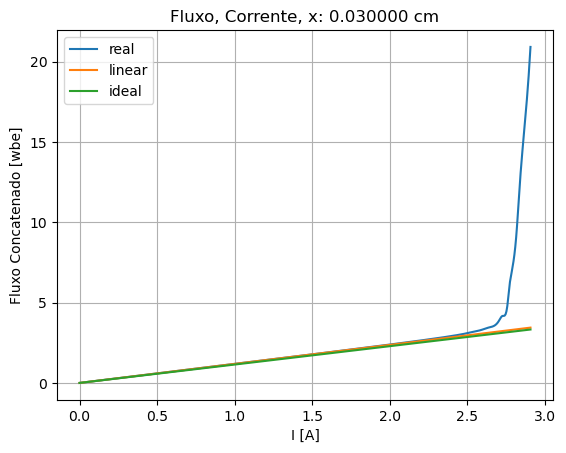

In [91]:
x = 10

plt.xlabel('I [A]')
plt.ylabel('Fluxo Concatenado [wbe]')
plt.title('Fluxo, Corrente, x: %f cm' % (pos[x]*100))

plt.plot(lambda_f, i_real[x] , label='real')
plt.plot(lambda_f, i_linear[x], label='linear')
plt.plot(lambda_f, i_ideal[x], label='ideal')

plt.grid()
plt.legend()
plt.show()

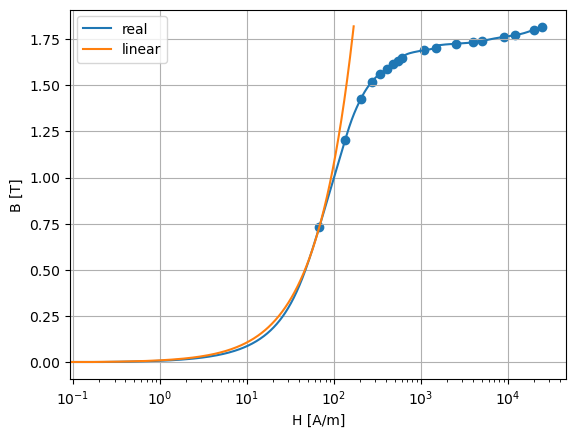

In [92]:
plt.ylabel('B [T]')
plt.xlabel('H [A/m]')
#plt.xlim([1, 1e4])
plt.xscale('log')
plt.scatter(H, B)
plt.plot(H_it, B_pnts, label='real')
plt.plot(H_linear, B_pnts, label='linear')
plt.grid()
plt.legend()
plt.show()

In [93]:
def forca_magnetica(corrente_bobina):
    I_interval = np.arange(0, corrente_bobina, corrente_bobina/NUMERO_DE_PONTOS)
    wc_real = np.zeros(shape=NUMERO_DE_PONTOS)
    wc_ideal = np.zeros(shape=NUMERO_DE_PONTOS)
    wc_linear = np.zeros(shape=NUMERO_DE_PONTOS)

    for idx in range(NUMERO_DE_PONTOS):
        flu_corrente_real = interp1d(i_real[idx], lambda_f, fill_value='extrapolate')
        flu_corrente_ideal = interp1d(i_ideal[idx], lambda_f, fill_value='extrapolate')
        flu_corrente_linear = interp1d(i_linear[idx], lambda_f, fill_value='extrapolate')

        lambda_real = flu_corrente_real(I_interval)
        lambda_ideal = flu_corrente_ideal(I_interval)
        lambda_linear = flu_corrente_linear(I_interval)

        wc_real[idx] = sp.integrate.trapezoid(lambda_real, I_interval)            
        wc_ideal[idx] = sp.integrate.trapezoid(lambda_ideal, I_interval)
        wc_linear[idx] = sp.integrate.trapezoid(lambda_linear, I_interval)  

    forca_real = derivative(interp1d(pos, wc_real, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
    forca_linear = derivative(interp1d(pos, wc_ideal, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
    forca_ideal = derivative(interp1d(pos, wc_linear, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))

    return forca_real, forca_linear, forca_ideal

In [94]:
forca_real_1, forca_linear_1, forca_ideal_1 = forca_magnetica(corrente_bobina=1)
forca_real_5, forca_linear_5, forca_ideal_5 = forca_magnetica(corrente_bobina=5)
forca_real_15, forca_linear_15, forca_ideal_15 = forca_magnetica(corrente_bobina=15)

C:\Users\Danil\AppData\Local\Temp\ipykernel_9804\859391136.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  forca_real = derivative(interp1d(pos, wc_real, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
c:\Users\Danil\anaconda3\Lib\site-packages\scipy\_lib\_finite_differences.py:145: RuntimeWarning: invalid value encountered in divide
  return val / prod((dx,) * n, axis=0)
C:\Users\Danil\AppData\Local\Temp\ipykernel_9804\859391136.py:21: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  forca_linear = derivative(interp1d(pos, wc_ideal, fill_value='extrapolate'), pos, dx=(pos/NUMERO_

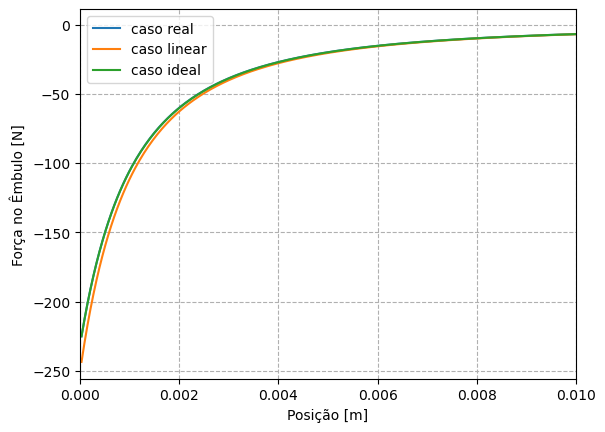

In [95]:
plt.ylabel('Força no Êmbulo [N]')
plt.xlabel('Posição [m]')
plt.xlim([0, 0.010])

plt.plot(pos, forca_real_1, label='caso real')
plt.plot(pos, forca_linear_1, label='caso linear')
plt.plot(pos, forca_ideal_1, label='caso ideal')

plt.grid(linestyle='--')
plt.legend()
plt.show()

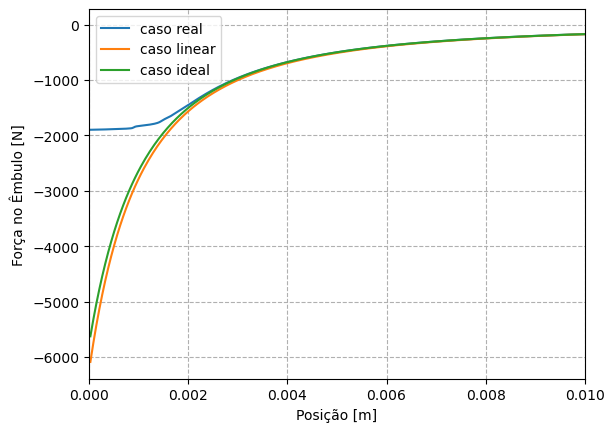

In [96]:
plt.ylabel('Força no Êmbulo [N]')
plt.xlabel('Posição [m]')
plt.xlim([0, 0.010])

plt.plot(pos, forca_real_5, label='caso real')
plt.plot(pos, forca_linear_5, label='caso linear')
plt.plot(pos, forca_ideal_5, label='caso ideal')

plt.grid(linestyle='--')
plt.legend()
plt.show()

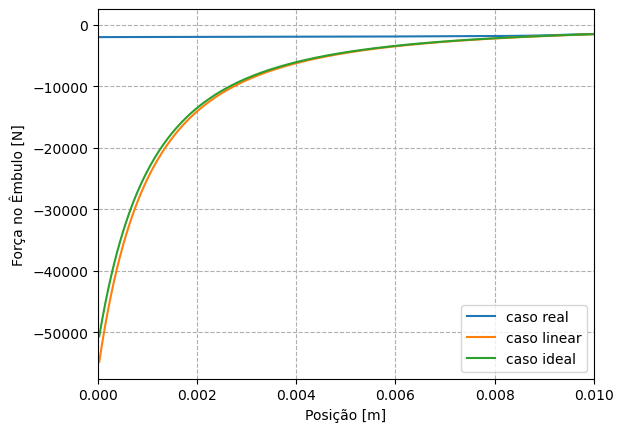

In [97]:
plt.ylabel('Força no Êmbulo [N]')
plt.xlabel('Posição [m]')
plt.xlim([0, 0.010])

plt.plot(pos, forca_real_15, label='caso real')
plt.plot(pos, forca_linear_15, label='caso linear')
plt.plot(pos, forca_ideal_15, label='caso ideal')

plt.grid(linestyle='--')
plt.legend()
plt.show()

In [98]:
ponto_5_mm = np.where(pos == 0.00501)

In [100]:
vetor_correntes = np.arange(0.1, 20, 0.1)
vetor_erro = np.zeros(vetor_correntes.shape[0])

for i in range(vetor_correntes.shape[0]):
    f_real, _, f_ideal = forca_magnetica(corrente_bobina=vetor_correntes[i])
    vetor_erro[i] = (f_real[ponto_5_mm]*-1 - f_ideal[ponto_5_mm]*-1) / (f_real[ponto_5_mm]*-1)

C:\Users\Danil\AppData\Local\Temp\ipykernel_9804\859391136.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  forca_real = derivative(interp1d(pos, wc_real, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
C:\Users\Danil\AppData\Local\Temp\ipykernel_9804\859391136.py:21: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  forca_linear = derivative(interp1d(pos, wc_ideal, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
C:\Users\Danil\AppData\Local\Temp\ipykernel_9804\859391136.py:22: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completel

In [117]:
erro_abs = abs(vetor_erro)
erro_abs_max5 = erro_abs[erro_abs < 0.05]

In [122]:
vetor_correntes[len(erro_abs_max5)-1]

9.3

In [121]:
erro_abs_max5[-1]

0.04657307036185536

In [109]:
np.where(vetor_erro == min(abs(vetor_erro)))

(array([40], dtype=int64),)